# Этап L1

**Задача:** первичный анализ данных, очищение данных.

**Итог работы:** проведен EDA, данные изучены, убраны все выбросы, пропуски и лишние данные.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')
sns.set_palette('rainbow')
from scipy.stats import chisquare
import datetime as dt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [ ]:
path = "/content/drive/MyDrive/WB School/data.csv.gzip"
df = pd.read_csv(path, compression='gzip')

## Этап L1.А. Обзор данных и выдумывание потенциальных фичей

Для начала поверхностно посмотрим на данные.

In [ ]:
def head_glimpse(data, col, figure_size=(18, 8), n=20, title_text="График", ylabel_text="Количество"):
  temp_df = df[col].value_counts().reset_index().rename(columns={"index": col, col: "count"}).sort_values(by="count", ascending=False)
  mean_count = temp_df["count"].mean()

  plt.figure(figsize=figure_size)
  plt.title(title_text)
  sns.barplot(x=col, y="count", data=temp_df.head(n))
  plt.xlabel(col)
  plt.ylabel(ylabel_text)
  plt.axhline(y=mean_count, linewidth=2, color="red")

### Шаг 1. Наиболее покупаемые товары


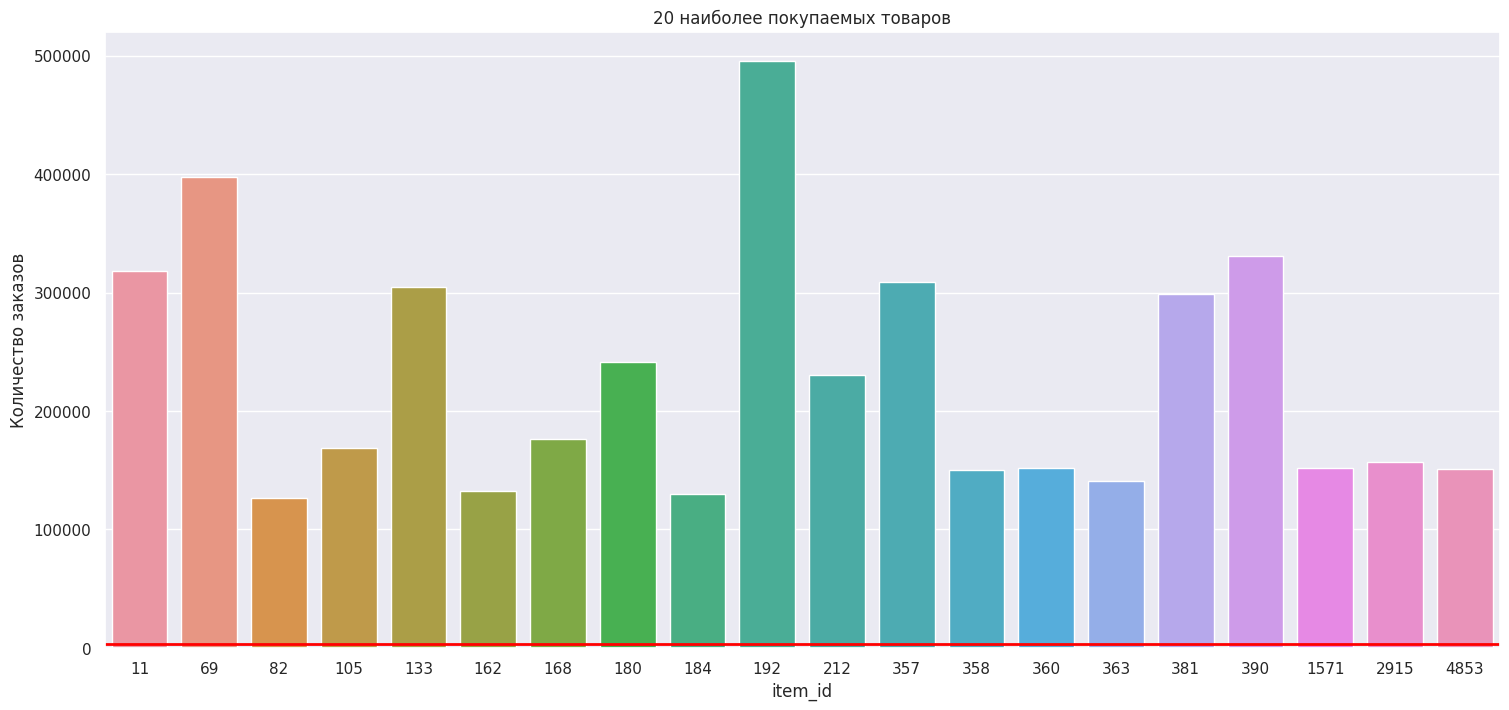

In [ ]:
head_glimpse(df, "item_id", title_text="20 наиболее покупаемых товаров", ylabel_text="Количество заказов")

### Шаг 2. Наиболее активные пользователи

Активность = количество заказов.

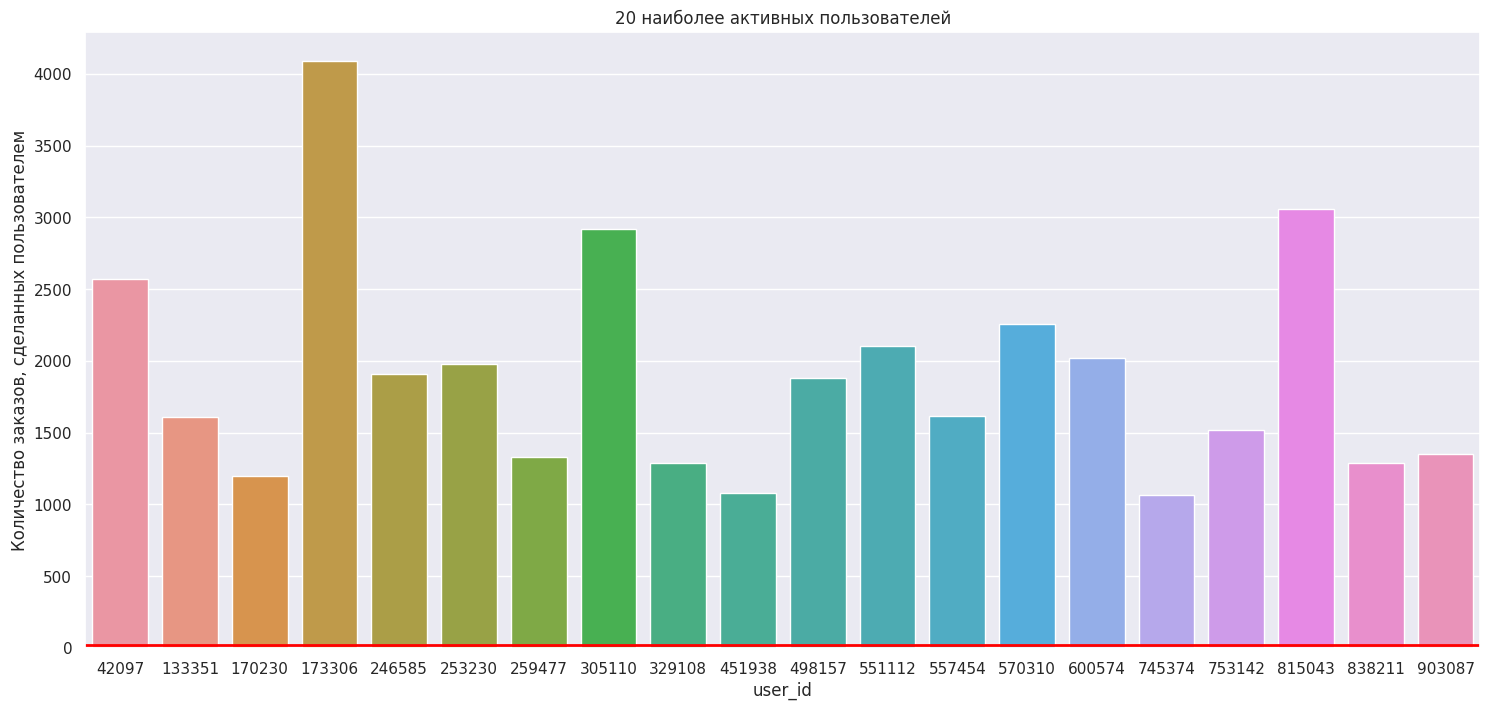

In [ ]:
head_glimpse(df, "user_id", title_text="20 наиболее активных пользователей", ylabel_text="Количество заказов, сделанных пользователем")

На обеих гистограммах красная горизонтальная линия почти лежит на оси OX, вероятно на уровне среднего числа заказов, свидетельствует о большой разнице в количестве заказов между товарами и покупателями.

### Шаг 3. 20 наиболее популярных товаров по количеству уникальных покупателей

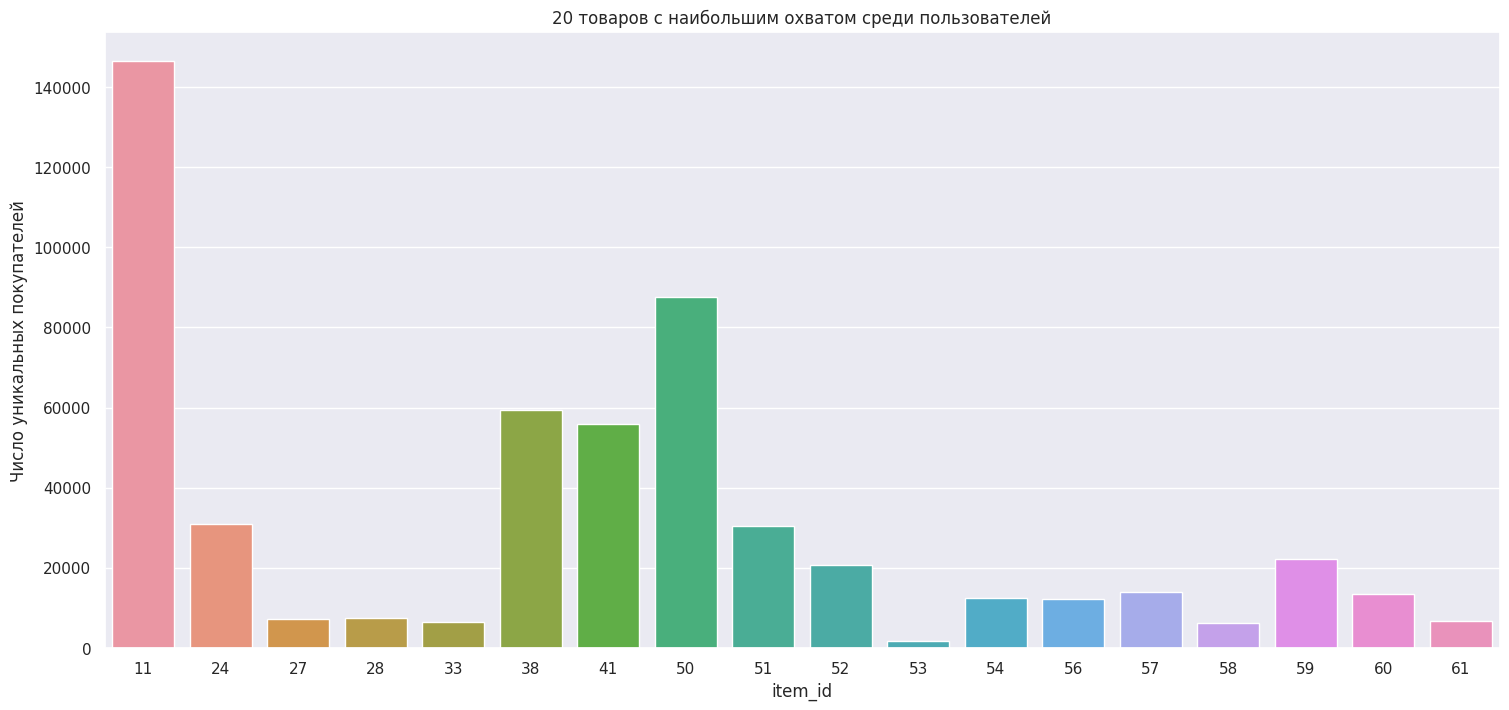

In [ ]:
top_items = df.groupby("item_id", as_index=False).user_id.nunique() \
  .rename(columns={"user_id": "unique_users"}).sort_values(by="unique_users", ascending=False)

plt.figure(figsize = (18, 8))
plt.title("20 товаров с наибольшим охватом среди пользователей")
sns.barplot(x = "item_id", y = "unique_users", data = top_items.head(18))
plt.xlabel("item_id")
plt.ylabel("Число уникальных покупателей");

**Вывод №1:** Построенные гистограммы показали, что далеко не все наиболее покупаемые товары имеют большой охват среди пользователей. Возможно, это свидетельствует о том, что, например, у товара №192 есть постоянные покупатели, которым он нравится. И наоборот, у товара №11 приблизительно 300k продаж, но лишь 140k пользоватей его преобрели, и, возможно, он им не понравился.

С другой точки зрения, может быть и так, что товар №192 является дешевым и повторяемым товаром, т.е. нужен регулярно, а товар №11 - нечто, не предполагающее частую покупку одним и тем же покупателем (например, мебель).

Сделанное наблюдение указывает на возможную необходимость очистки данных, ведь товар мог быть многократно заказан несколькими или даже одним пользоваетелем. С выбросами поработаем на **Этапе L1.Б**.

In [ ]:
top_items.unique_users.sum(), 100 * top_items.unique_users.sum() / (df.user_id.nunique() * df.item_id.nunique())

(14070857, 0.20281518495878476)

**Вывод №2:** всего имеется 14kk взаимодействией пользователей с товарами, и этот вывод несравнимо более важный. С точки зрения модели матричного разложения, в матрице взаимодействий *R* будет лишь 0,2% непустых ячеек.

### Шаг 4. Распределение покупок по месяцам

In [ ]:
df["order_ts"] = pd.to_datetime(df.order_ts, format="%Y-%m-%d %H:%M:%S")
df["month"] = df["order_ts"].dt.month

#### Шаг 4.1. Гистограмма количества заказов в зависимости от месяца

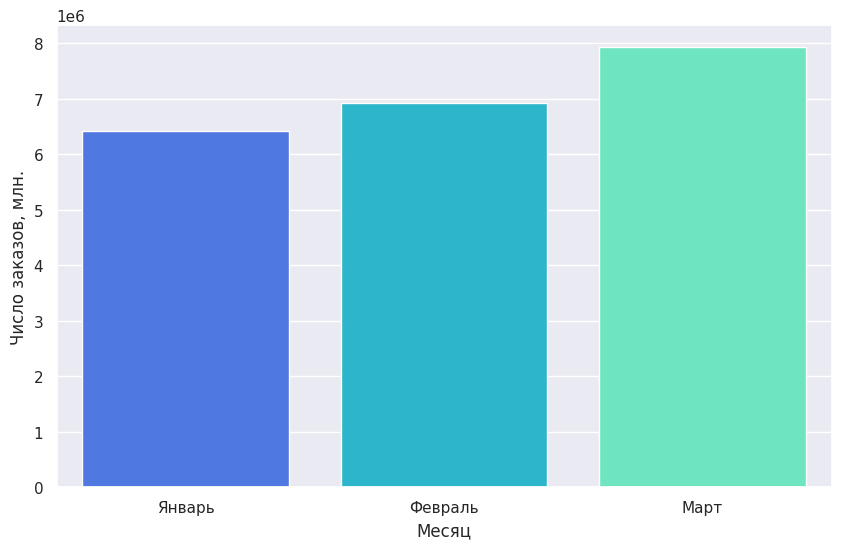

In [ ]:
orders_monthly = df.groupby("month", as_index=False).month.value_counts()
months = ["Январь", "Февраль", "Март"]
orders_monthly.month = months

plt.figure(figsize = (10, 6))
sns.barplot(x="month", y="count", data=orders_monthly)
plt.xlabel("Месяц")
plt.ylabel("Число заказов, млн.");

#### Шаг 4.2. Хи-квадрат тест на значимость разницы


In [ ]:
chisquare(f_obs=orders_monthly["count"]).pvalue * 1000

0.0

p-value < 0.05 и в целом около 0, поэтому продажи по месяцам различаются значимо. Переменная месяца заказа могла бы иметь место, если бы были исторические данные и по другим месяцам.


На **шаге 6.3** подойдём к проверке значимости переменной месяца иначе и построим линейную регрессию, куда включим её.

### Шаг 5. Время суток суток покупки.

Насколько различается объём продаж в дневное (06:00-18:00) и ночное (18:00-06:00) время суток.

In [ ]:
df["order_ts"] = pd.to_datetime(df["order_ts"])
df["day_night"] = "night"
df.loc[(df.order_ts.dt.hour >= 6) & (df.order_ts.dt.hour < 18), "day_night"] = "day"
df.day_night.value_counts()
chisquare(f_obs=df.day_night.value_counts())
df.day_night.value_counts()
13006417 - 8259367

4747050

Хи-квадрат тест показал, что распределение числа покупок в дневное и ночное время отличается значимо. При этом в дневное время сделано на 4.7kk покупок больше. **Поэтому переменная времени суток нам может пригодиться**.


### Шаг 6. Распределение количества заказов по дням

Во-первых, посмотрим на распределение частоты покупок по дням. Во-вторых, изучим, значимо ли выделяются объёмы продаж в праздничные и прочие особые общественные даты.

#### Шаг 6.1. Распределение заказов по дням

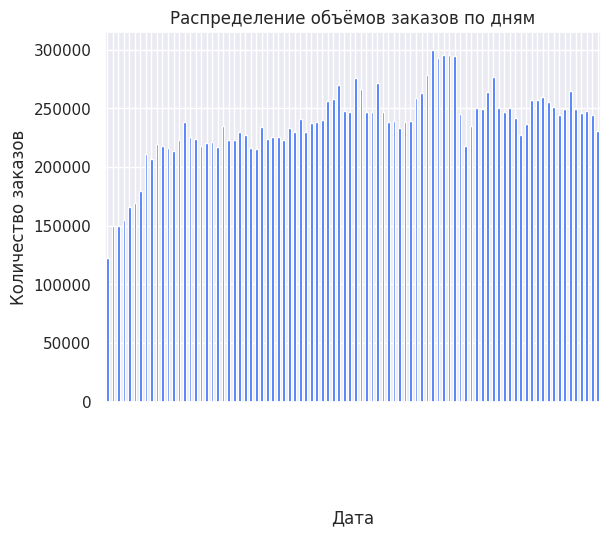

In [ ]:
special_dates = ["2023-01-01", "2023-01-07", "2023-01-13", # Январь
                 "2023-02-14", "2023-02-23", # Феварль
                 "2023-03-08"] # Март
special_dates = [dt.datetime.strptime(date, "%Y-%m-%d").date() for date in special_dates]
df["is_special_day"] = "usual"
df.loc[df.order_ts.dt.date.isin(special_dates), "is_special_day"] = "special"
df.groupby("is_special_day", as_index=False).is_special_day.count()

# Построим отдельный датафрейм, состоящий из дней и количества покупок в этот день по всем дням.
df["day"] = df.order_ts.dt.date
extra_df = df[["day", "is_special_day"]].groupby("day", as_index=False).count() \
  .rename(columns={"is_special_day": "count"})

extra_df.plot.bar(x="day", y="count", legend=False)
plt.xticks(color="w")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.title('Распределение объёмов заказов по дням');

#### Шаг 6.2. Значимость статуса "праздничный" для количества заказов в этот день

Для того, чтобы определить, просиходит ли статистически значимое изменение объёма заказов в праздничные дни, построим линейную регрессию: Таргет - количество заказов в день (count), интересующая переменная - является ли день праздничным, (is_special_day = 1, если день праздничный).

In [ ]:
extra_df["is_special_day"] = "usual"
extra_df.loc[extra_df.day.isin(special_dates), "is_special_day"] = "special"
extra_df.loc[extra_df.is_special_day == "special", "is_special_day"] = "1"
extra_df.loc[extra_df.is_special_day == "usual", "is_special_day"] = "0"
extra_df.is_special_day = extra_df.is_special_day.astype("float")

X = extra_df[["is_special_day"]]
y = extra_df[["count"]]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     6.733
Date:                Mon, 15 May 2023   Prob (F-statistic):             0.0111
Time:                        21:23:10   Log-Likelihood:                -1056.0
No. Observations:                  90   AIC:                             2116.
Df Residuals:                      88   BIC:                             2121.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.385e+05   3326.565     71.

**Вывод:** p-value коэффициента при дамми-переменной "праздничности" дня меньше порога 0.05, поэтому переменная является статистически значимой. При этом коэффициент отрицательный, поэтому **в праздничные дни продажи падают**. Возможно, оценка коэффициента является смещённой, т.к. не учтены никакие иные регрессоры.

#### Шаг 6.3. Значимость переменной месяца для количества заказов

In [ ]:
extra_df["month"] = None
extra_df["day"] = pd.to_datetime(extra_df.day, format='%Y-%m-%d')
extra_df.loc[(extra_df.day >= "2023-01-01") & (extra_df.day <= "2023-01-31"), "month"] = "январь"
extra_df.loc[(extra_df.day >= "2023-02-01") & (extra_df.day <= "2023-02-28"), "month"] = "февраль"
extra_df.loc[(extra_df.day >= "2023-03-01") & (extra_df.day <= "2023-03-31"), "month"] = "март"

extra_df = pd.get_dummies(extra_df, columns=["month"])
X = extra_df[["month_январь", "month_февраль"]]
y = extra_df[["count"]]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     38.69
Date:                Mon, 15 May 2023   Prob (F-statistic):           9.57e-13
Time:                        21:37:31   Log-Likelihood:                -1030.6
No. Observations:                  90   AIC:                             2067.
Df Residuals:                      87   BIC:                             2075.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.557e+05   4157.134     61.507

**Вывод:** переменная *month_март* выбрана как базовая. Результаты позволяют сделать вывод, что в феврале продажи значимо ниже, чем в марте, а в феврале продажи упали незначительно, т.к. *p-values(month_январь)* < 0.05, *p-values(month_март)* > 0.05.

### Шаг 7. Заготовка для дисконтирования заказов в таргете

In [ ]:
df["order_ts"] = pd.to_datetime(df["order_ts"])
df["day"] = df.order_ts.dt.date

df_cut = df[df[["user_id", "item_id"]].duplicated(keep=False)]
df_periods = df_cut.groupby(["user_id", "item_id"], as_index=False).agg({"day": lambda x: list(x)})

,user_id,item_id,day
0,3,11,"[2023-01-30, 2023-02-02, 2023-02-02, 2023-02-0..."
1,3,41,"[2023-01-30, 2023-02-27, 2023-02-27]"
2,3,93,"[2023-03-15, 2023-03-15, 2023-03-19]"
3,3,180,"[2023-03-27, 2023-03-27]"
4,3,185,"[2023-02-27, 2023-03-22, 2023-03-19]"
...,...,...,...
3734086,1057264,457,"[2023-02-25, 2023-02-17, 2023-02-25, 2023-02-2..."
3734087,1057264,4088,"[2023-02-12, 2023-02-25]"
3734088,1057264,4986,"[2023-02-25, 2023-02-25]"
3734089,1057264,5408,"[2023-02-17, 2023-03-08]"


## Этап L1.Б. Очистка данных

Данные не требуют очистки/заполнения в общем понимании этого этапа работы потому, что:

1.   Нет незаполненных или содержащих пробелы ячеек;
2.   Например, в статье https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093 в датасете с фильмами отбросили юзеров с менее, чем 1000 оценками, а также фильмы с оценкой ниже 3. Однако мы имеем дело с неявным фидбеком, и у нас нет информации о рейтинге товаров;
3.   В данных нет тестового периода работы сервиса, который отстоял бы от остальной выборки, как, например, в статье https://habr.com/en/companies/otus/articles/648891/.

### Разбираемся с дубликатами

В данных содержится 2kk дубликатов, а также есть взаимодействия, явно выделяющиеся на фоне остальных. В вопросе отбрасывании таких наблюдений, как мне кажется, можно поступить 2 путями.

#### Подход 1. Выбросить выбросы и дубликаты

Отбросить все дубликаты и все выбросы. Нам важен сам факт взаимодействия, т.е. покупал ли пользовтаель товар в определённый момент времени, и нам не так интересно, сколько раз он его купил в конкретную секунду: некорректно будет выдать в рекомендациях 7 раз один и тот же товар в одной выдаче. Поэтому можно отбросить в *df* строки, которые полностью повторяют друг друга, а таких, как оказалось, 2kk. При отбрасывании полностью повторяющихся наблюдений мы не потеряем ни одного пользователя и ни одного товара:

In [ ]:
df_duplicates = df[df.duplicated()]

df_duplicates_users = df_duplicates.drop_duplicates(subset=["user_id"])
df_duplicates_items = df_duplicates.drop_duplicates(subset=["item_id"])

len(df_duplicates_users[~df_duplicates_users["user_id"].isin(df["user_id"].unique())])
len(df_duplicates_users[~df_duplicates_users["item_id"].isin(df["item_id"].unique())])

0

#### Подход 2. Оставить выбросы и дубликаты

Однако, мне кажется, что в данном случае не следует отбрасывать дубликаты. Обсудим, почему.
На Этапе L0 были выведены общая форма функции потерь и общий вид таргета. Изначальный таргет не упускал много имеющейся информации, поэтому доопределим его.

Во-первых, чем позже был совершён заказ, тем более актуальную информацию о предпочтениях пользоватля он отображает, отчего ему необходимо придать вес  бОльший, чем веса более ранних заказов. Будем суммировать заказы по моменту времени покупки и дисконтировать каждое слогаемое суммы на величину, над которой ещё надо подумать. Например, автор https://habr.com/en/companies/otus/articles/649533/, скорее всего, взял сигмоиду от разницы между концом обследуемого промежутка и моментом совершения заказа. Также, возможно, подойдёт логарифм. Для общности пока обозначим эту функцию за *discounter* (прямо как DCG).

Во-вторых, от количества покупок перейдём к отношению объёма заказов в момент времени *t* (По-моему, где-то был доклад, как правильно это сделать), чтобы количество также отображало предпочтения пользовтаеля. Поэтому отбрасывать дубликаты нельзя, ведь то, что человек заказывает товар, например, по 100 единиц, является важной информацией.

В итоге приходим к таргету, в котором учтена и "свежесть" заказа, и его объём. Записан в конце Этапа L0.